In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

### Not important plotting helper function

In [2]:
def dynamic_plotting(samples):
    plt.ion()

    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 3

    fig1 = plt.figure(1)
    ax1_1 = fig1.add_subplot(121)
    fig1.canvas.draw()

    z= 100
    b = np.ones([1])

    for i in range(z):
        # update data 
        b = np.append(b, [samples[i*100:(i+1)*100]])
    
        # re-plot area 1 of fig1  
        ax1_1.clear()
        ax1_1.set_xlim (0, 10000)
        ax1_1.set_ylim (0, 1)
        ax1_1.plot(b)
    
        # redraw fig 1 
        fig1.canvas.draw()

# Define Probabilities

**Learn how the author deinfes probabilities in dictionaries for specific problem.**

In [3]:
prob_type = 0.25
prob_region = 0.55
prob_prod = {(1,1): 0.9, (1,0): 0.75, (0,1):0.8, (0,0):0.6}
prob_usage= {(1,): 0.5, (0,): 0.3}
prob_price = {(1,): 0.3, (0,): 0.6}
prob_cancel = {(1,1): 0.4, (1,0): 0.2, (0,1): 0.25, (0,0): 0.1}


# The last to lines are dictionary that enables building a computational graph
# In reject sampling, it is no used yet.
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}
dep = {0: 'no', 1: 'no', 2: [0,1], 3: [2], 4: [3], 5: [3,4]}

# Reject Sampling

**Use Tuple as dictionary keys, you need to know:**                                       
https://docs.python.org/3/faq/design.html#why-are-there-separate-tuple-and-list-data-types

The hash table implementation of dictionaries uses a hash value calculated from the key value to find the key. If the key were a mutable object, its value could change, and thus its hash could also change. But since whoever changes the key object can’t tell that it was being used as a dictionary key, it can’t move the entry around in the dictionary. Then, when you try to look up the same object in the dictionary it won’t be found because its hash value is different. If you tried to look up the old value it wouldn’t be found either, because the value of the object found in that hash bin would be different.

If you want a dictionary indexed with a list, simply convert the list to a tuple first; the function tuple(L) creates a tuple with the same entries as the list L. Tuples are immutable and can therefore be used as dictionary keys.

In [4]:
samples = []
samples.append(0)

accept_count = 0
reject_count = 0

for i in range(10000):
    # 1 for hospital, 0 for Doctor's office
    t = np.random.choice([1,0], p = [prob_type, 1 - prob_type])
    
    # 1 for north, 0 for south
    r = np.random.choice([1,0], p = [prob_region, 1 - prob_region])
    
    # 1 for one product, 0 for two or more products
    p = np.random.choice([1,0], p = [prob_prod[(t,r)], 1 - prob_prod[(t,r)]])
    
    # 1 for low usage, 0 for high usage
    u = np.random.choice([1,0], p = [prob_usage[(p,)], 1 - prob_usage[(p,)]])
    
    # 1 for price increase, 0 for no price increase
    pr = np.random.choice([1,0], p = [prob_price[(u,)], 1 - prob_price[(u,)]])
    
    # 1 for cancel, 0 for not cancel
    c = np.random.choice([1,0], p = [prob_cancel[(u,pr)], 1 - prob_cancel[(u,pr)]])
    
    # since we want P(cancel |r = north)
    if r == 0:
        reject_count += 1
        
    else:
        avg = (samples[accept_count] * accept_count + c) / (accept_count + 1)
        samples.append(avg)
        accept_count += 1
        # here we don't store sampled values, we store our belief
        
        

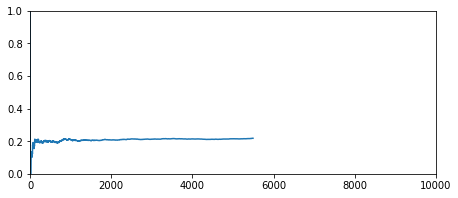

In [5]:
dynamic_plotting(samples)

In [6]:
print(samples[-1])

print("Proportion of samples rejected: {}".format(reject_count/10000))
print("Conditional probability with rejection sampling: {}".format(samples[9999-reject_count]))

0.21777130371449377
Proportion of samples rejected: 0.4508
Conditional probability with rejection sampling: 0.21781096339464573


### 知识点：Dynamic update Average, Probabilities within one piece of business code.

#### If we want to update mean                

Suppose we have a dictionary of means, each value is updated from its previous element.    
You update a value with previous mean and current value.     

now comes a new sample with value = `value`:            

Since we know             
```python
avg = sums / count
```

Now we update average `avg`              
```python
new_count = count + 1
new_sums = count* avg + value
new_avg = new_sums / new_count
new_avg = (count * avg) / (count + 1)
```

#### If we want to update a probability             

*Now we have a list of probabilities [values between 0 and 1]*    

Since we know
```python
prob = success / trials
```

Now comes a new value, that is either 0 or 1, 0 for failed, 1 for success.       

```python
new_success = trials *  prob +  value
new_trails = trials + 1
new_prob = (trials * prob) +  value / (trials + 1)
```

所以作者省去了存储一堆0和1， 只存储我当前的belief， 一段合格的工程代码。                  
当我们使用Epsilon Greddy 算法的时候，这个就特别有用了。                              

In [7]:
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}
dep = {0: 'no', 1: 'no', 2: [0,1], 3: [2], 4: [3], 5: [3,4]}

In [8]:
# there are 6 vairables
variable = set(np.arange(6))

# the 2nd variable is the given variable
given = set([1])

# other variables are free
free_var = list(variable.difference(given))

# randomly pick a sample.
val = np.array([1,1,1,1,1,1])

In [9]:
samples = list()

# append the 1st result from the 1st sample
samples.append(val[5])

for i in range(10000):
    
    # randomly choose a free variable
    var = np.random.choice(free_var)
    
    # if this variable has no parent variable
    # the variable can be drawn with its own probability distribution
    if dep[var]=='no':
        var_prob = prob[var]
        
    # if the variable has parent variable
    # find the current value of all the parent variables
    # find the probability of the current variable
    else:
        var_prob = prob[var][tuple(val[dep[var]])]
        
    # randomly draw a sample of the current variable
    rand = np.random.uniform()
    if rand <= var_prob:
        new_val = 1
    else:
        new_val = 0
    
    # set the value of current variable with new sampled value
    val[var] = new_val
    
    # now I have i samples, update probability
    avg = (samples[i]*i+val[5])/(i+1)
    samples.append(avg)

### Review course 
Suppose we have a graph like that

In [229]:
import networkx as nx

class ProbGraph():
    
    
    def __init__(self, edgelist):
        '''Initialize a Bayesian graph'''
        self.edgelist = edgelist
        self.G = nx.from_edgelist(self.edgelist, create_using=nx.DiGraph)
        
        
    def _draw_graph(self,G):
        '''Simple graph draw function'''
        layout = nx.spring_layout(G)
        fig, ax = plt.subplots(figsize = (8,6))
        nx.draw(G, with_labels = True, alpha = 0.8, node_size= 1000, pos = layout)
        plt.show()
        
        
    def get_graph(self):
        '''Return the networkx graph'''
        return self.G
    
    
    def draw_full_graph(self):
        '''Draw full bayesian network'''
        self._draw_graph(self.G)
       
    
    def markov_linkage(self, n):
        '''Get markov linkage, which is a subgraph of the bayesian network'''
        # find all childrens of a node
        childs = list(self.G.successors(n))
        
        # find all parents of a node
        parents = list(self.G.predecessors(n))
        
        # find all parents of all childs of n
        childs_parents = [list(self.G.predecessors(c)) for c in childs]
        childs_parents = [n for l in childs_parents for n in l]
        
        # make a subgraph
        subnodes = list(set(childs + parents + childs_parents + [n]))
        subG = self.G.subgraph(subnodes)
        return subG
    
    
    def draw_markov_linkage(self,n):
        '''Draw markov linkage on a give node n'''
        subG = self.markov_linkage(n)
        self._draw_graph(subG)
        
        
    def D_separate(self, joints, givens = None):
        
        '''Preform d-separation'''
        
        givens = givens if givens else []

        # find all variables mentioned
        variables = givens + joints
        subsets = []

        # loop through variables, find parents and parents of parenets
        for variable in variables:
            all_edges = list(nx.edge_dfs(G,variable, orientation='reverse'))
            subset = [[s,t] for s,t, _ in all_edges]
            subsets.append([n for l in subset for n in l])
            
        # subset should also include original variables, but exclude
        subsets = list(set([n for l in subsets for n in l]).union(joints))

        # constract ancestral graph A
        A = nx.DiGraph(G.subgraph(subsets))

        # for all nodes in A, connect parents of joint childs
        for node in A.nodes():
            predecessors = list(A.predecessors(node))
            if len(predecessors) >=2:
                for u,v in list(combinations(predecessors,2)):
                    A.add_edge(u,v)

        # unorient the graph 
        A = nx.Graph(A)

        # remove the givens
        subsets = [n for n in A.nodes() if n not in givens]

        A = nx.Graph(A.subgraph(subsets))
        
        return A

**Initialize and darw a graph**

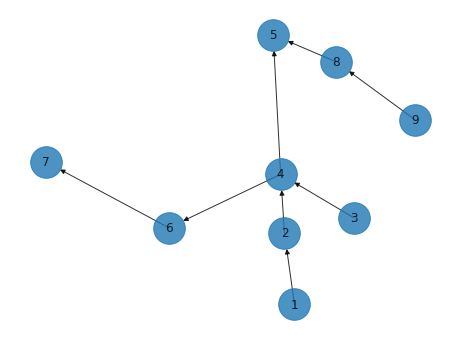

In [232]:
edge_list = [[1,2],[2,4],[3,4],[4,5],[4,6],[6,7],[8,5],[9,8]]
PGraph = ProbGraph(edge_list)
PGraph.draw_full_graph()

**Node 4 is the only child of node 3**        
**Node 4 has another parent 2**     
**Markov linkage include nodes $N = \{2,3,4\}$**

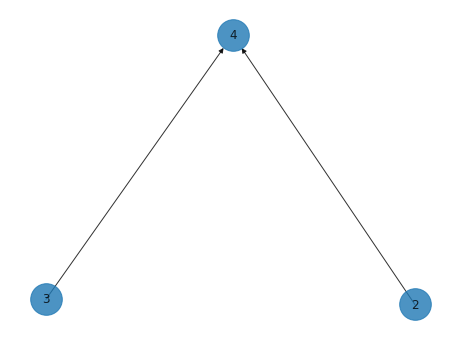

In [223]:
PGraph.draw_markov_linkage(3)

**Node 6 has a parent 4 and a son 7**
**Markov linkage include nodes $N = \{4,6,7\}$**

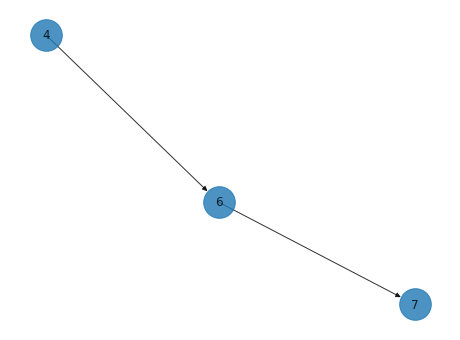

In [224]:
PGraph.draw_markov_linkage(6)

**Test on another graph**

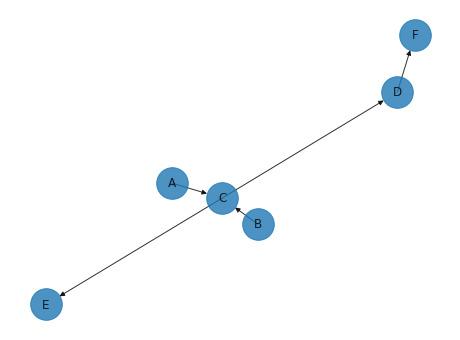

In [225]:
edge_list = [['A','C'],['B','C'],['C','D'],['C','E'],['D','F']]
PGraph = ProbGraph(edge_list)
PGraph.draw_full_graph()

*C has parents A and B, children D, E, which have no other parents*
*$N = \{A,B,C,D,E\}$*

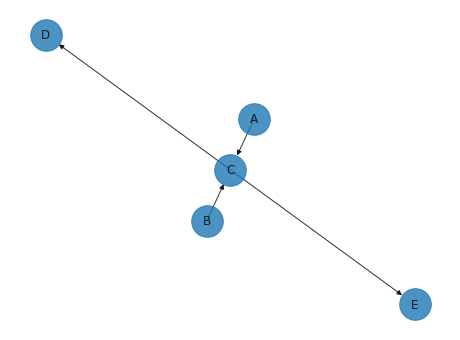

In [226]:
PGraph.draw_markov_linkage('C')

**Next we do D-separation**

In [227]:
edge_list = [['A','C'],['B','C'],['C','D'],['C','E'],['D','F']]
G = nx.from_edgelist(edge_list, create_using=nx.DiGraph)

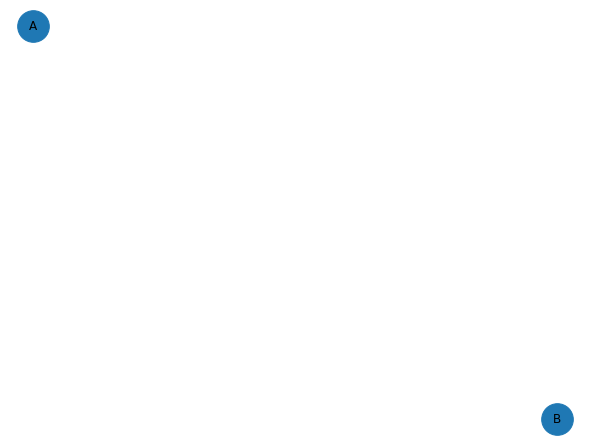

In [228]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['A','B'])

nx.draw(A, with_labels = True, node_size = 1000)

**There's not edge between A & B, we say A and B are absolutely independent**

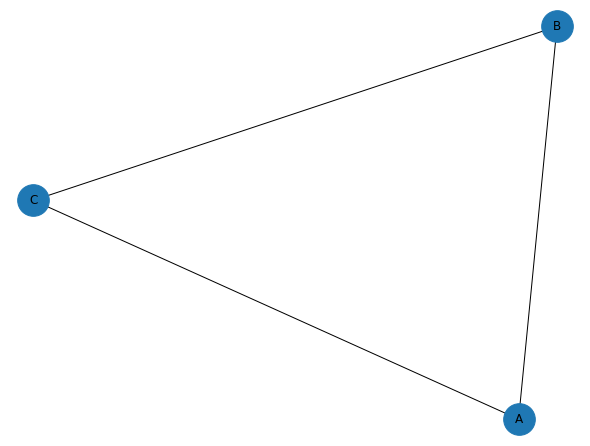

In [234]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['A','B'],givens =  ['D','F'])

nx.draw(A, with_labels = True, node_size = 1000)

**There is an edge between A and B, A and B are not required to be independent give D and F**

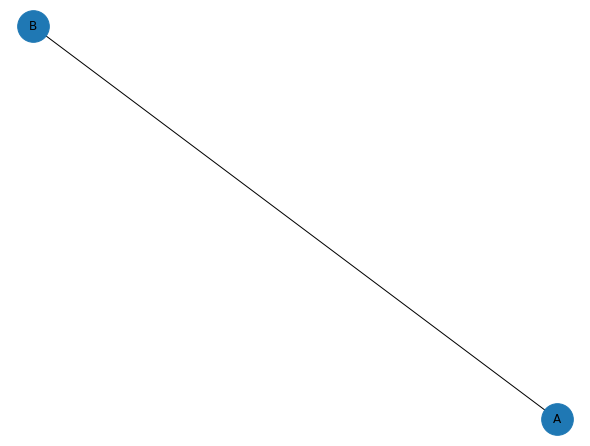

In [235]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['A','B'],givens =  ['C'])

nx.draw(A, with_labels = True, node_size = 1000)

**Has edge: A and B are not required to be indepndent give C**

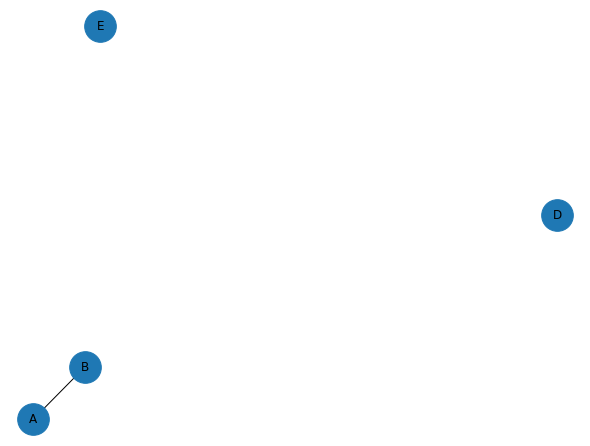

In [236]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['D','E'],givens =  ['C'])

nx.draw(A, with_labels = True, node_size = 1000)

**D and E are conditionally independent give C**

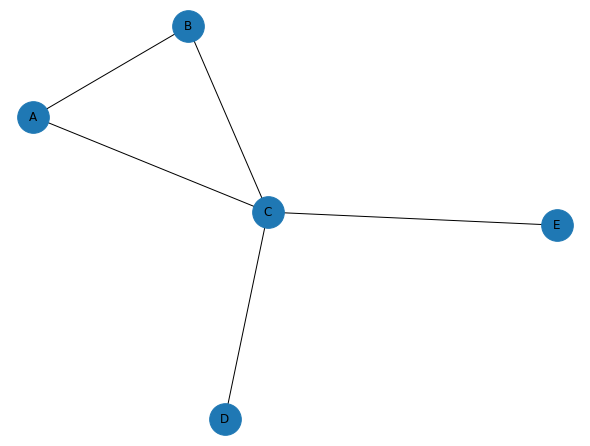

In [237]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['D','E'])

nx.draw(A, with_labels = True, node_size = 1000)

**D and E are connected through C, they are not absolute indendent**

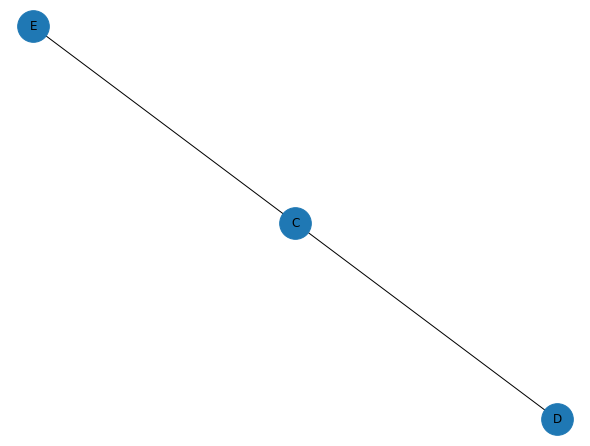

In [238]:
PGraph = ProbGraph(edgelist=edge_list)

A = PGraph.D_separate(joints = ['D','E'],givens = ['A','B'])

nx.draw(A, with_labels = True, node_size = 1000)

**Given A, and B, DE are connected through C, not conditionally indepndent**

All the tests are passed, haha

**There are still more complex cases that are not considered yet. TO BE IMPLEMENTED...**

## Gibbs sampling review

**Firstly, we want to review the probability tables, in a real world, we're not going to represent everthing as 0 and 1, because the events are hard to recognize and review in code**

In [239]:
prob_type = 0.25
prob_region = 0.55
prob_prod = {(1,1): 0.9, (1,0): 0.75, (0,1):0.8, (0,0):0.6}
prob_usage= {(1,): 0.5, (0,): 0.3}
prob_price = {(1,): 0.3, (0,): 0.6}
prob_cancel = {(1,1): 0.4, (1,0): 0.2, (0,1): 0.25, (0,0): 0.1}
prob = {0: prob_type, 1: prob_region, 2: prob_prod, 3: prob_usage, 4: prob_price, 5: prob_cancel}

In [245]:
# these 2 things are extreamly simple
prob_type = 0.25
prob_region = 0.55

# yet a distribution is prefered
prob_type = {'Hospical':0.25, 'DO':0.75}
prob_region = {'North':0.55, 'South':0.45}



**As long as we find a joint child, we need to define a <font color = 'red'>Cartesian Product of its parents</font>**

**Or to say <font color = 'red'> Conditional Probability Distribution (CPD)</font>**

In [272]:
import pandas as pd
import itertools

In [281]:
parents = [prob_type, prob_region]
column_names = ['Type','Region']
potential_values = ['=1','>=2']
keys = [list(p.keys()) for p in parents] + [potential_values]
table = pd.DataFrame(list(itertools.product(*keys)), columns = column_names + ['NProducts'])
table['probability'] = 0
table

,Type,Region,NProducts,probability
0,Hospical,North,=1,0
1,Hospical,North,>=2,0
2,Hospical,South,=1,0
3,Hospical,South,>=2,0
4,DO,North,=1,0
5,DO,North,>=2,0
6,DO,South,=1,0
7,DO,South,>=2,0


*The probabilities are zeros, which are not correct, and should be inferred from observed data.*